# Command
- Decouple the object that invokes the operation from the one that knows how to perform it.

- The client creates a command object that can be executed at a later date
- This object knows about a receiver object that manages its own internal state when the command is executed on it
- One or more invoker objects execute the command at the correct time

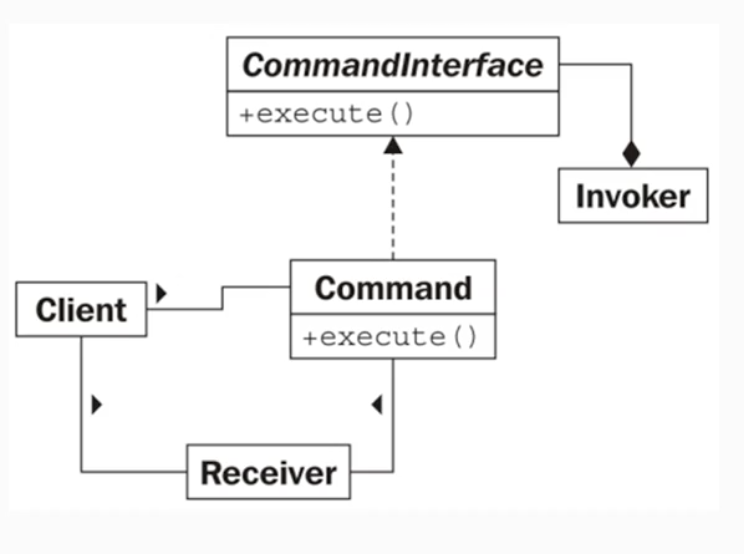

In [1]:
class Screen(object):
    def __init__(self, text=''):
        self.text = text
        self.clip_board = ''
        
    def cut(self, start=0, end=0):
        self.clip_board = self.text[start:end]
        self.text = self.text[:start] + self.text[end:]
        
    def paste(self, offset=0):
        self.text = self.text[:offset] + self.clip_board + self.text[offset:]
        
    def clear_clipboard(self):
        self.clip_board = ''
        
    def length(self):
        return len(self.text)
    
    def __str__(self):
        return self.text
    

class ScreenCommand:
    def __init__(self, screen):
        self.screen = screen
        self.previous_state = screen.text
        
    def execute(self):
        pass
    
    def undo(self):
        pass
    

class CutCommand(ScreenCommand):
    def __init__(self, screen, start=0, end=0):
        super().__init__(screen)
        self.start = start
        self.end = end
        
    def execute(self):
        self.screen.cut(start=self.start, end=self.end)
        
    def undo(self):
        self.screen.clear_clipboard()
        
        
class PasteCommand(ScreenCommand):
    def __init__(self, screen, offset=0):
        super().__init__(screen)
        self.offset = offset
        
    def execute(self):
        self.screen.paste(offset=self.offset)
        
    def undo(self):
        self.screen.clear_clipboard()
        self.screen.text = self.previous_state
        
        
class ScreenInvoker:
    def __init__(self):
        self.history = []
        
    def store_and_execute(self, command):
        command.execute()
        self.history.append(command)
        
    def undo_last(self):
        if self.history:
            self.history.pop().undo()

In [2]:
screen = Screen('hello world')
screen.__str__()

'hello world'

In [3]:
cut = CutCommand(screen, start=5, end=11)
client = ScreenInvoker()

In [4]:
client.store_and_execute(cut)

In [5]:
screen.__str__()

'hello'

In [6]:
paste = PasteCommand(screen, offset=0)
client.store_and_execute(paste)

In [7]:
screen.__str__()

' worldhello'

In [8]:
client.undo_last()

In [9]:
screen.__str__()

'hello'

# Interpreter

- Define a grammatical representation for a language and an interpreter to interpret the grammar

- Client : build the tree of expressions, the interpret method of the top item in the tree is then called
- Context : used to store any information that needs to be available to all expression objects
- ExpressionBase : base class defining the interpret method
- TerminalExpression : can be interpreted in a single object
- NonterminalExpression : aggregates containing one or more further expressions, each of which may be terminal or non-terminal

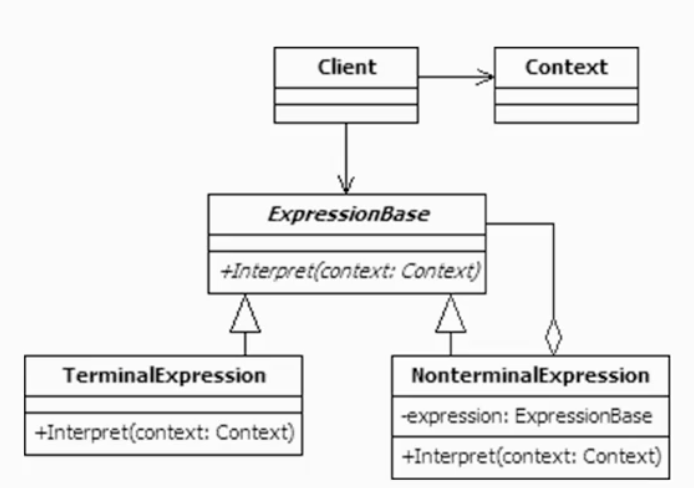

In [18]:
class Expression:
    def interpret(self, text): pass
    

class TerminalExpression(Expression):
    def __init__(self, word):
        self.word = word
        
    def interpret(self, text):
        words = text.split()
        if self.word in text:
            return True
        else:
            return False
        

class OrExpression(Expression):
    def __init__(self, exp1, exp2):
        self.exp1 = exp1
        self.exp2 = exp2
        
    def interpret(self, text):
        return self.exp1.interpret(text) or self.exp2.interpret(text)
    

class AndExpression(Expression):
    def __init__(self, exp1, exp2):
        self.exp1 = exp1
        self.exp2 = exp2
        
    def interpret(self, text):
        return self.exp1.interpret(text) and self.exp2.interpret(text)
    

john = TerminalExpression('John')
henry = TerminalExpression('Henry')
mary = TerminalExpression('Mary')
sarah = TerminalExpression('Sarah')

In [19]:
rule1 = AndExpression(john, henry)

In [20]:
rule2 = OrExpression(mary, rule1)

In [21]:
rule3 = AndExpression(sarah, rule2)

In [22]:
rule3.interpret('Sarah')

False

# State

- Alow a object to alter its behavior when its internal state changes

- Define a context class to present a single interface to the outside world
- Define a State abstract base class
- Represent the different states of the state machine as derived classes of the state base clas
- Maintain a pointer to the current state in the context class
- To change the state of the state machine, change the current state pointer

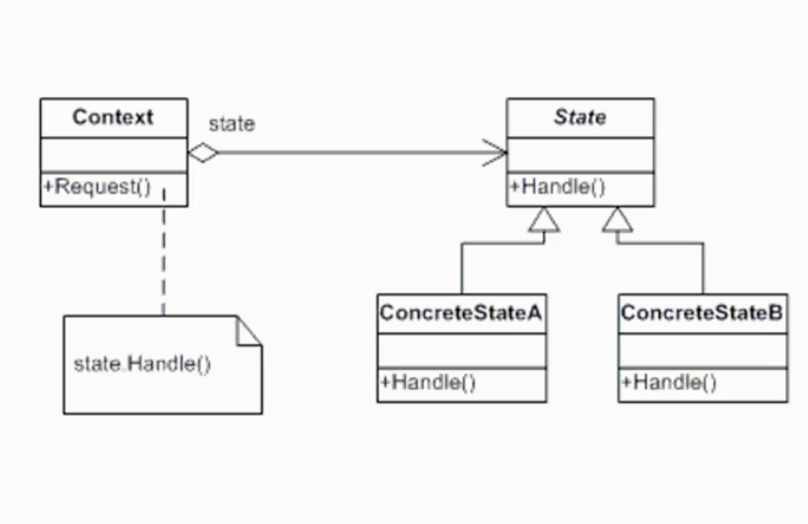

In [2]:
class ComputerState:
    name = "state"
    allowed = []
    
    def switch(self, state):
        if state.name in self.allowed:
            print("Current:", self, " => switched to new state", state.name)
            self.__class__ = state
        else:
            print("Current:", self, " => switching to ", state.name, "not possible.")
            
    def __str__(self):
        return self.name
    

class Off(ComputerState):
    name = "off"
    allowed = ["on"]
    
    
class On(ComputerState):
    name = "on"
    allowed = ["off", "suspend", "hibernate"]
    
    
class Suspend(ComputerState):
    name = "suspend"
    allowed = ["on"]
    
    
class Hibernate(ComputerState):
    name = "hibernate"
    allowed = ["on"]
    

class Computer:
    def __init__(self):
        self.state = Off()
        
    def change(self, state):
        self.state.switch(state)

In [3]:
c = Computer()
c.state.__str__()

'off'

In [4]:
c.change(On)

Current: off  => switched to new state on


In [6]:
c.change(Suspend)

Current: on  => switched to new state suspend


In [7]:
c.change(Hibernate)

Current: suspend  => switching to  hibernate not possible.


In [8]:
c.change(On)

Current: suspend  => switched to new state on


In [9]:
c.change(Off)

Current: on  => switched to new state off


# Chain of Responsibility

- Avoids coupling the sender of a request to the receiver by gibing more than one object a chance to handle the request.

- Number and/or type of handler objects unknown at the point the client sends the request 
- Multiple and dynamically configurable receivers, each only needs to maintain a reference to the its immediate successor
- Immediate response not required

In [13]:
class Car:
    def __init__(self, name, water, fuel, oil):
        self.name = name
        self.water = water
        self.fuel = fuel
        self.oil = oil
        
    def is_fine(self):
        if self.water >= 20 and self.fuel >= 5 and self.oil >= 10:
            print("Car is good to go")
            return True
        else:
            return False
        
    
class Handler:
    def __init__(self, seccessor=None):
        self._successor = seccessor
        
    def handle_request(self, car):
        if not car.is_fine() and self._successor is not None:
            self._successor.handle_request(car)
            

class WaterHandler(Handler):
    
    def handle_request(self, car):
        if car.water < 20:
            car.water = 100
            print("Added water")
        super().handle_request(car)
        
    
class FuelHandler(Handler):
    
    def handle_request(self, car):
        if car.fuel < 5:
            car.fuel = 100
            print("Added fuel")
        super().handle_request(car)
        

class OilHandler(Handler):
    
    def handle_request(self, car):
        if car.oil < 10:
            car.oil = 100
            print("Added oil")
        super().handle_request(car)

In [14]:
garage_handler = OilHandler(FuelHandler(WaterHandler()))

In [15]:
car = Car("my car", 1, 1, 1)

In [16]:
garage_handler.handle_request(car)

Added oil
Added fuel
Added water
Car is good to go


In [17]:
car = Car("my car", 5, 5, 5)
garage_handler.handle_request(car)

Added oil
Added water
Car is good to go


# Observer

- Define a one-to-many depnedency between objects so that when one object changes state, all its dependents are notified and updated automatically.

- The subject is the "keeper" of the data model/business logic
- Delegate all "view" functionality to decoupled and distinct Obserer objects, which register theselves with the Subject
- When the Subject changes, it broadcasts to all registered Observers.

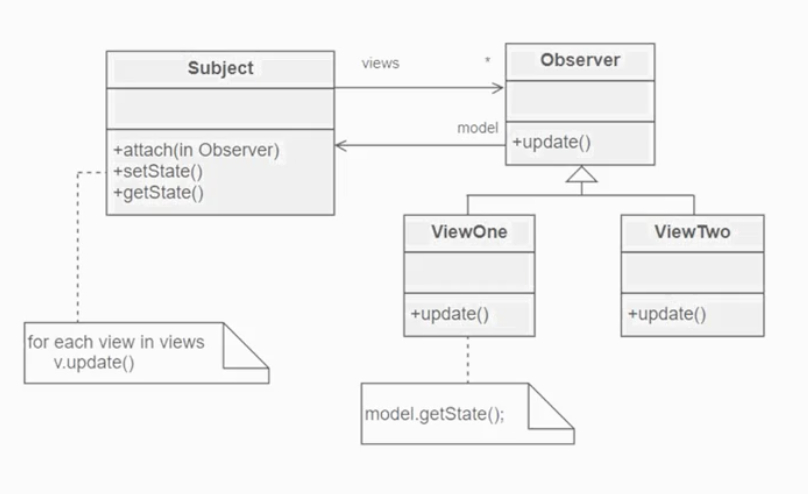

In [19]:
class Observable:
    
    def __init__(self):
        self.observers = []
        
    def register(self, observer):
        if not observer in self.observers:
            self.observers.append(observer)
            
    def unregister(self, observer):
        if observer in self.observers:
            self.observers.remove(observer)
        
    def unregister_all(self):
        if self.observers:
            del self.observers[:]
            
    def update_observers(self, *args, **kwargs):
        for observer in self.observers:
            observer.update(*args, **kwargs)
            
            
class Observer:
    def update(self, *args, **kwargs):
        pass
    
    
class AmericanStockMarket(Observer):
    def update(self, *args, **kwargs):
        print("American stock market received: {}\n{}".format(args, kwargs))
        
        
class EuropeanStockMarket(Observer):
    def update(self, *args, **kwargs):
        print("European stock market received: {}\n{}".format(args, kwargs))

In [20]:
really_big_company = Observable()
american_observer = AmericanStockMarket()
really_big_company.register(american_observer)
european_observer = EuropeanStockMarket()
really_big_company.register(european_observer)
really_big_company.update_observers("important_update", msg="CEO unexpectedly resigns")

American stock market received: ('important_update',)
{'msg': 'CEO unexpectedly resigns'}
European stock market received: ('important_update',)
{'msg': 'CEO unexpectedly resigns'}


# Strategy

- Define a family of algorigthms, encapsulate each one, and make them interchangeable. Strategy lets the algorithm vary independently from the clients that use it

- Open-closed principle: software entities (classes, modules, functions, and so on) should be open for extension, but closed for modification
- Program to an interface, not an implementation

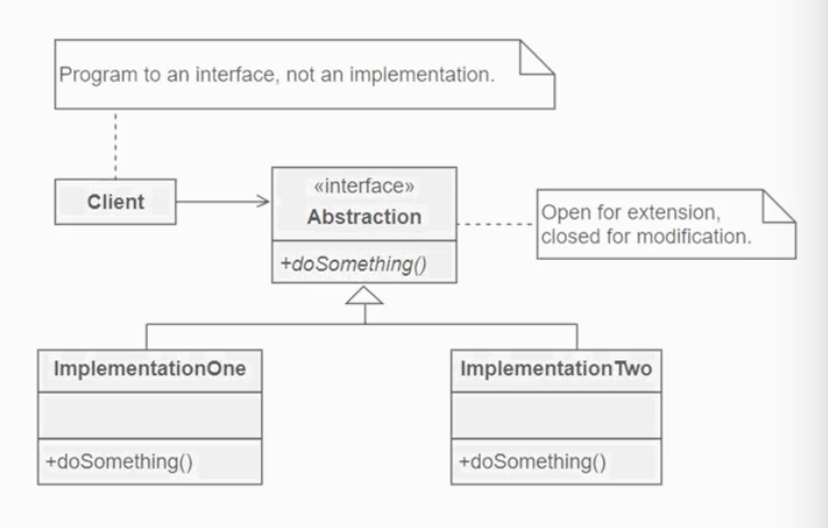

In [28]:
class PrimeFinder:
    
    def __init__(self):
        self.primes = []
        
    def calculate(self, limit):
        """Will calculate all the primes below limit."""
        pass
    
    def out(self):
        """Prints the list of primes prefixed  with which algorithm made it."""
        print(self.__class__.__name__)
        for prime in self.primes:
            print(prime)
            
            
class HardCodedPrimeFinder(PrimeFinder):
    def calculate(self, limit):
        hardcoded_primes = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47]
        primes = []
        for prime in hardcoded_primes:
            if (prime < limit):
                self.primes.append(prime)
                
            
class StandardPrimeFinder(PrimeFinder):
    def calculate(self, limit):
        self.primes = [2]
        
        for number in range(1, limit, 2):
            is_prime = True
            for prime in self.primes:
                if (number % prime == 0):
                    is_prime = False
                    break
                if (is_prime):
                    self.primes.append(number)

In [29]:
class PrimeFinderClient:
    
    def __init__(self, limit):
        self.limit = limit
        
        if limit <= 50:
            self.finder = HardCodedPrimeFinder()
        else:
            self.finder = StandardPrimeFinder()
            
    def get_primes(self):
        self.finder.calculate(self.limit)
        self.finder.out()

In [30]:
p = PrimeFinderClient(50)

In [31]:
p.get_primes()

HardCodedPrimeFinder
2
3
5
7
11
13
17
19
23
29
31
37
41
43
47


In [32]:
q = PrimeFinderClient(100)
q.get_primes()

StandardPrimeFinder
2
1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
31
33
35
37
39
41
43
45
47
49
51
53
55
57
59
61
63
65
67
69
71
73
75
77
79
81
83
85
87
89
91
93
95
97
99


# Memento

- Capture and externalize an object's internal state so that the object can be returned to this state later

- Originator : the object that knows how to save itself
- Caretaker : the object that knows why and when the originator needs to save/resotre itself
- Memento : the state box written and read by the Originator, and shepherded by the Caretaker

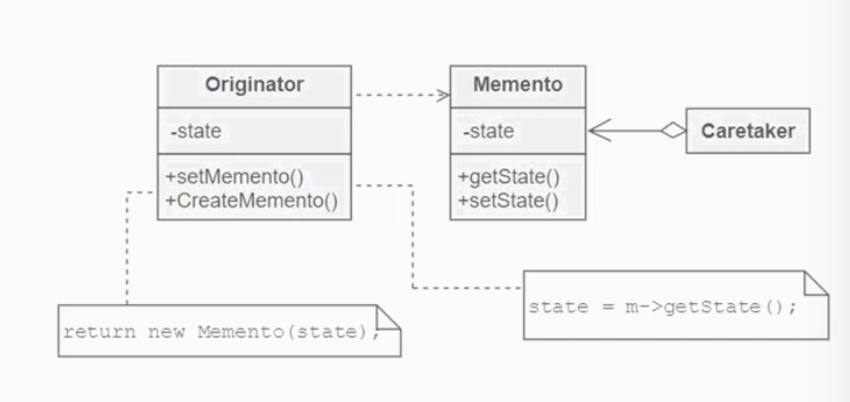

In [38]:
import copy


class Memento:
    
    def __init__(self, data):
        for attribute in vars(data):
            setattr(self, attribute, copy.deepcopy(getattr(data, attribute)))
            
            
class Undoable:
    
    def __init__(self):
        self.__last = None
        
    def save(self):
        self.__last = Memento(self)
        
    def undo(self):
        for attribute in vars(self):
            setattr(self, attribute, getattr(self.__last, attribute))
            
    
class Data(Undoable):
    
    def __init__(self):
        super(Data, self).__init__()
        self.numbers = []

In [39]:
d = Data()
repeats = 10
for i in range(repeats):
    d.save()
    d.numbers.append(i)

In [40]:
d.save()

In [41]:
d.numbers

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [42]:
for i in range(repeats):
    d.undo()
    print(d.numbers)

[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4]
[0, 1, 2, 3]
[0, 1, 2]
[0, 1]
[0]
[]


In [43]:
vars(d)

{'_Undoable__last': <__main__.Memento at 0x1150a15f8>, 'numbers': []}

In [44]:
class A:
    a = "a"
    b = "b"
    c = "c"

vars(A)

mappingproxy({'__module__': '__main__',
              'a': 'a',
              'b': 'b',
              'c': 'c',
              '__dict__': <attribute '__dict__' of 'A' objects>,
              '__weakref__': <attribute '__weakref__' of 'A' objects>,
              '__doc__': None})

# Template

- Define the skeleton of an algorithm, deferring some steps to client subclasses. Let subclasses redefine certain steps of an algorithm without changing the algorithm's structure.

 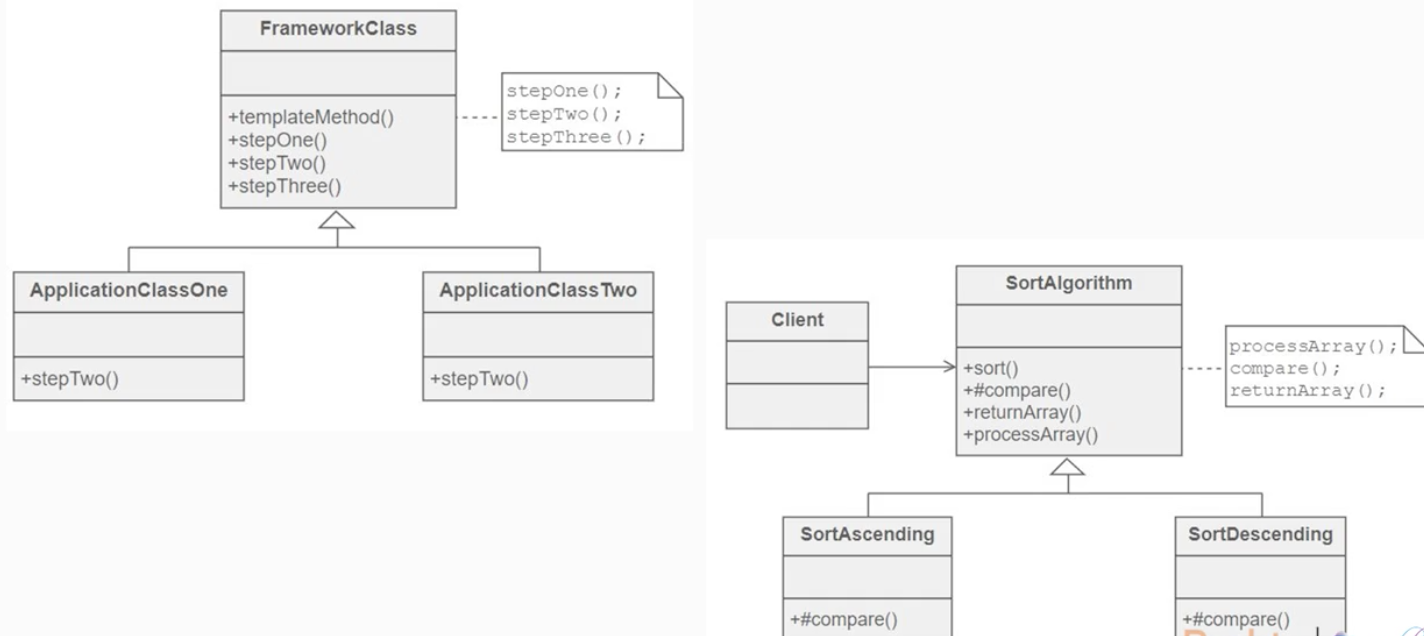

In [47]:
class MakeMeal:
    
    def buy_ingredients(self, money):
        if money < self.cost:
            assert 0, "Not enough money to buy ingredients"
            
    def prepare(self):
        pass 
    
    def cook(self):
        pass
    
    def go(self, money):
        self.buy_ingredients(money)
        self.prepare()
        self.cook()
        
        
class MakePizza(MakeMeal):
    def __init__(self):
        self.cost = 3
        
    def prepare(self):
        print("Prepare Pizza - make the dough and add toppings")
        
    def cook(self):
        print("Cook Pizza - cook in the oven on gas mark 8 for 10 minutes")
        
        
class MakeCake(MakeMeal):
    def __init__(self):
        self.cost = 2
        
    def prepare(self):
        print("Prepare Cake - mix ingredients together and pour into a cake tin")
        
    def cook(self):
        print("Cook Cake - bake in the oven on gas mark 6 for 20 minutes")

In [50]:
p = MakePizza()
p.go(5)

Prepare Pizza - make the dough and add toppings
Cook Pizza - cook in the oven on gas mark 8 for 10 minutes


In [51]:
p.go(2)

AssertionError: Not enough money to buy ingredients

In [52]:
c = MakeCake()
c.go(1)

AssertionError: Not enough money to buy ingredients

# Reactive Programming

- Extends the observer pattern
- Composing asynchronous and event-based programs by using observable sequences
- Treat streams of asynchronous events with the same sort of simple, composable operations that you use for collections of data items like arrays
- It frees you from tangled webs of callbacks, and thereby makes your code more readable and less prone to bugs
- Abstract away concerns about things like synchoronization, thread-safety, concurrent data structures and non-blocking I/O

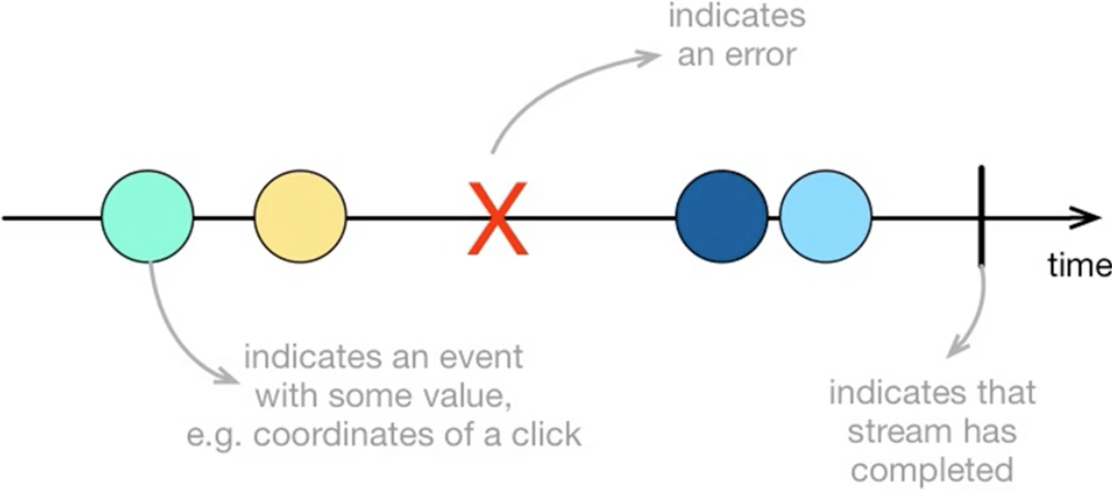

- Reactive Extensions for PYthon (RxPY) is a set of libraries for reactive programming
- Asynchronous data streams are represented with Observables. Multiple streams from diverse sources(for example, stock quote, Tweets, computer events) are supported
- The Observable type implements static query operators which allow you to easily filter, map, reduce, compose and perform time-based operations on multiple events
- Concurrency in data/event streams can be parametrized using Schedulers

In [1]:
!python --version

Python 3.6.6


In [5]:
from rx import Observer


class MyObserver(Observer):
    def on_next(self, x):
        print(f"Got: {x}")
    
    def on_error(sefl, e):
        print(f"Got error: {e}")
        
    def on_completed(self):
        print("Sequence completed")
              
              

In [6]:
from rx import Observable

In [7]:
xs = Observable.from_iterable(range(10))

In [8]:
d = xs.subscribe(MyObserver())

Got: 0
Got: 1
Got: 2
Got: 3
Got: 4
Got: 5
Got: 6
Got: 7
Got: 8
Got: 9
Sequence completed


In [9]:
xs = Observable.from_(range(10))

In [10]:
d = xs.subscribe(print)

0
1
2
3
4
5
6
7
8
9


In [11]:
xs = Observable.from_(range(10))
d = xs.filter(lambda x : x % 2).subscribe(print)

1
3
5
7
9


In [12]:
xs = Observable.from_(range(10))
d = xs.map(lambda x: x * 2).subscribe(print)

0
2
4
6
8
10
12
14
16
18


In [14]:
xs = Observable.range(1, 10)
ys = Observable.from_('abcde')
zs = xs.merge(ys).subscribe(print)

a
1
b
2
c
3
d
4
e
5
6
7
8
9
10


# Spaghetti Code